## JWST Pipeline Validation Testing Notebook: NIRISS/SOSS Time Series Observation, pt. 2
**Instruments affected**: NIRISS

### Table of Contents
1. [Imports](#Imports_ID)

2. [Introduction](#intro)

3. [The `assign_wcs` step](#assign_wcs)

4. [The `extract_2d` step](#extract2d)

5. [The `flat_field` step](#flatfield)

### <a id=#Imports_ID>Imports</a>

Here are the lirbaries being imported here and why:

- `numpy` for numerical calculations.
- `matplotlib.pyplot` for plots.
- `astropy.io.fits` for importing fits files.
- `jwst.pipeline.calwebb_spec2` for using the CalWebb Spec 2 stage.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.signal import medfilt
import os

from astropy.io import fits
from jwst.pipeline import calwebb_spec2
from jwst import datamodels

Version of the pipeline we are testing:

In [2]:
import jwst
print(jwst.__version__)

0.16.1


## <a id='intro'> Introduction </a>

In this notebook we'll be testing that the Stage 2 of the CalWebb Spec pipeline works as intended as a whole. We'll stop after every step to quickly check that the results make sense. The whole set of steps ran by TSOs by this first Stage of the CalWebb Pipeline can be found [<a href="https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2">here</a>]. In what follows, we'll have one section associated to each step, calibrating the data sequentially and exploring the outputs accordingly.

## <a id='groupscale'> The `assign_wcs` step </a>

We first test and validate the `assign_wcs` step. This step simply associates a WCS object with the whole science exposure, which in turn allows to extract positions and wavelengths with a simple call. Let's add this to the rateint products:

In [4]:
calwebb_spec2.assign_wcs_step.AssignWcsStep.call('output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits', output_dir='output',save_results=True)

2020-07-30 00:12:39,299 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   Unknown reference type 'pars-assignwcsstep'
2020-07-30 00:12:39,301 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2020-07-30 00:12:39,587 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('output/data_k2-141_superbiasstep_corrected_1_rampfitstep.fits',).
2020-07-30 00:12:39,588 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2020-07-30 00:13:29,914 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2020-07-30 00:13:40,186 - stpipe.AssignWcsStep - INFO - Saved model in output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits
20

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits>

All right! Let's check that the WCS information is on the headers now:

In [3]:
hdul_wcs = fits.open('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits')
exposure = datamodels.SpecModel('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits')

In [4]:
column, row, order = 2047, 255, 2
ra, dec, wavelength = exposure.meta.wcs(column, row, order)
print(ra,dec,wavelength)

350.9165458333333 -1.189291666666667 0.0


Great --- it works. One sligthly confusing detail is that the documentation for this step suggests that you have to ingest five values, whereas apparently three suffice for NIRISS/SOSS at least. Below we'll test the wavelength solution that comes out of this; however, let's check if the RA and DEC in WCS makes sense. To this end, let's extract the RA and DECs in the headers from the `awesimsoss` simulations. Let's compare:

In [9]:
diff_ra, diff_dec = hdul_wcs['PRIMARY'].header['TARG_RA']-ra,hdul_wcs['PRIMARY'].header['TARG_DEC']-dec
print(diff_ra,diff_dec)

0.0 0.0


Good! The very same results.

Now, to test the wavelength solution, let's note that given a column and a row in the detector level (and an order), this information returns the position and wavelength at that position. Let's create a map of wavelengths for order 1, 2 and 3 to test how this works in detail:

In [13]:
rows,columns = hdul_wcs['SCI'].data[0,:,:].shape
wavelength_maps = np.zeros([3,rows,columns])
for order in [1,2,3]:
    for row in range(rows):
        for column in range(columns):
            wavelength_maps[order-1,row,column] = exposure.meta.wcs(column, row, order)[-1]

All right --- let's plot those maps now:

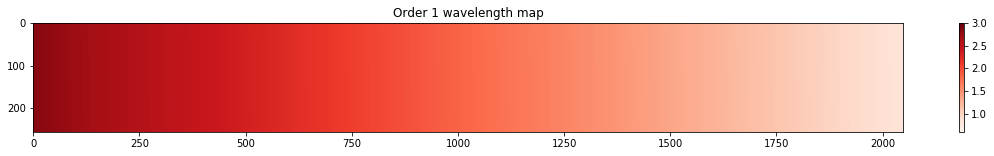

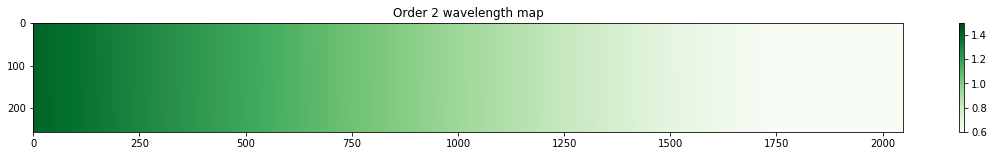

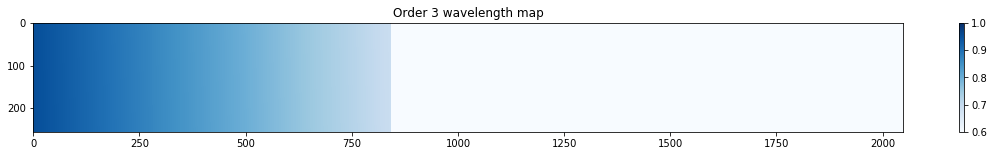

In [25]:
plt.figure(figsize=(20,2))
plt.title('Order 1 wavelength map')
im1 = plt.imshow(wavelength_maps[0,:,:])
im1.set_clim(0.6,3.0)
im1.set_cmap('Reds')
cb1 = plt.colorbar()

plt.figure(figsize=(20,2))
plt.title('Order 2 wavelength map')
im2 = plt.imshow(wavelength_maps[1,:,:])
im2.set_clim(0.6,1.5)
im2.set_cmap('Greens')
cb2 = plt.colorbar()

plt.figure(figsize=(20,2))
plt.title('Order 3 wavelength map')
im3 = plt.imshow(wavelength_maps[2,:,:])
im3.set_clim(0.6,1.0)
im3.set_cmap('Blues')
cb3 = plt.colorbar()


They look pretty good! These wavelength ranges match exactly the known wavelength ranges for the three NIRISS/SOSS orders.

This step, by the way, should not do anything on the data itself, so we don't do any analyses on that. Given all the outputs from the WCS make sense, <font color='green'>**we consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='extract2d'> The `extract_2d` step </a>

We now move to the `extract_2d` step which extract 2D spectra from the images. In theory, this step is skipped by NIRISS/SOSS --- but let's go ahead and try running it using our AssignWCS products:

In [28]:
calwebb_spec2.extract_2d_step.Extract2dStep.call('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits', output_dir='output',save_results=True)

2020-07-30 15:47:49,685 - CRDS - ERROR -  Error determining best reference for 'pars-extract2dstep'  =   Unknown reference type 'pars-extract2dstep'
2020-07-30 15:47:49,743 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.
2020-07-30 15:47:51,875 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args ('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits',).
2020-07-30 15:47:51,882 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'apply_wavecorr': True, 'extract_orders': None, 'extract_height': None, 'grism_objects': None, 'mmag_extract': 99.0}
2020-07-30 15:48:37,765 - stpipe.Extract2dStep - INFO - EXP_TYPE is NIS_SOSS
2020-07-30 15:48:37,788 - stpipe.Extract2

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_extract2dstep.fits>

Indeed, it says "not supported" for `NIS_SOSS` --- let's see what the outputs of this look like:

In [10]:
hdul_e2d = fits.open('output/data_k2-141_superbiasstep_corrected_1_extract2dstep.fits')
print(hdul_wcs.info())
print(hdul_e2d.info())

Filename: output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     160   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 308)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 308)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [50440044B]   
None
Filename: output/data_k2-141_superbiasstep_corrected_1_extract2dstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 Imag

No real change in the data structure. Let's continue.

## <a id='flatfield'> The `flat_field` step </a>

This step applies the flat field correction to our NIRISS/SOSS data. Let's run our WCS products through this:

In [31]:
calwebb_spec2.flat_field_step.FlatFieldStep.call('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits', output_dir='output',save_results=True)

2020-07-30 15:55:38,266 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   Unknown reference type 'pars-flatfieldstep'
2020-07-30 15:55:38,422 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2020-07-30 15:55:39,881 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('output/data_k2-141_superbiasstep_corrected_1_assignwcsstep.fits',).
2020-07-30 15:55:39,884 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False}
2020-07-30 15:56:30,819 - stpipe.FlatFieldStep - WARNING - Keyword CDP_INTERNAL_FLAT does not correspond to an existing DQ mnemonic, so will be ignored
2020-07-30 15:57:03,655 - stpipe.FlatFieldStep - INFO - Extracting ma

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits>

The step was run --- let's see the differences in the science products:

Filename: output/data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     177   ()      
  1  SCI           1 ImageHDU        17   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 308)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 308)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (2048, 256, 308)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [50440308B]   
None
Reference file used for flat field: crds://jwst_niriss_flat_0181.fits


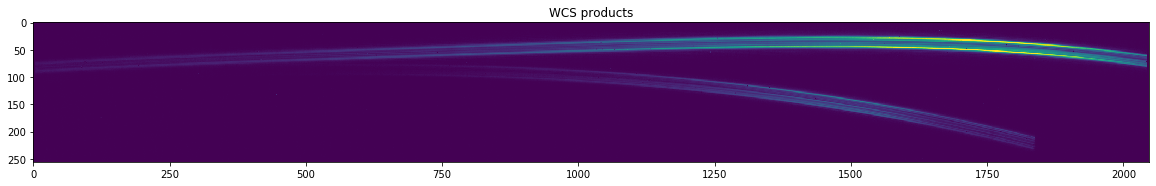

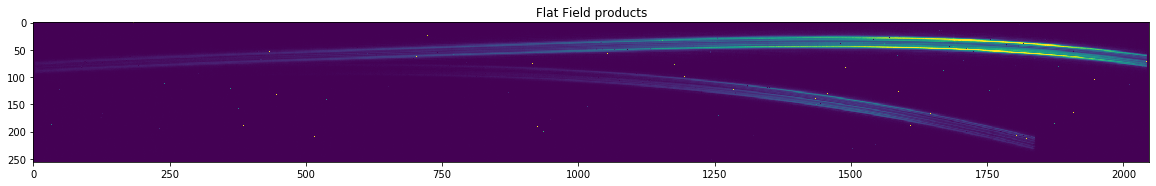

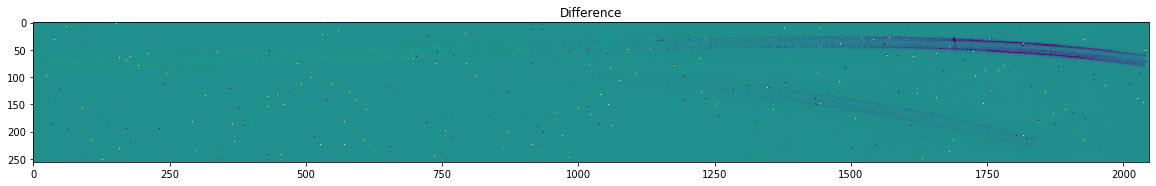

In [11]:
hdul_flat = fits.open('output/data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits')
print(hdul_flat.info())
print('Reference file used for flat field:',hdul_flat['PRIMARY'].header['R_FLAT'])

plt.figure(figsize=(20,10))
plt.title('WCS products')
im = plt.imshow(hdul_wcs['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Flat Field products')
im = plt.imshow(hdul_flat['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Difference')
im = plt.imshow(hdul_wcs['SCI'].data[0,:,:] - hdul_flat['SCI'].data[0,:,:])
im.set_clim(-100,100)

In theory the step only divides the slopes by the flat. Let's see if that's indeed the case using the reference file used by the pipeline to correct the first integration slopes:

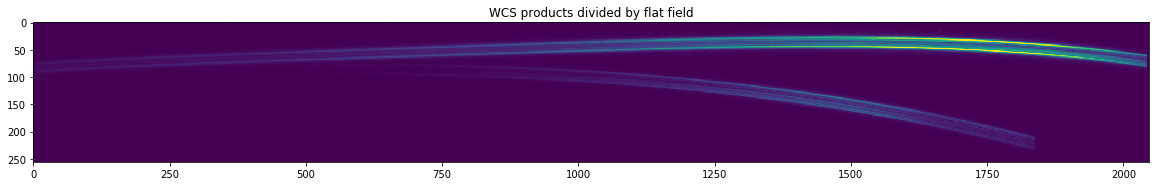

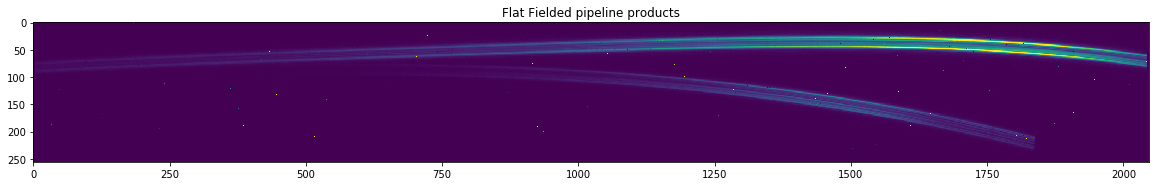

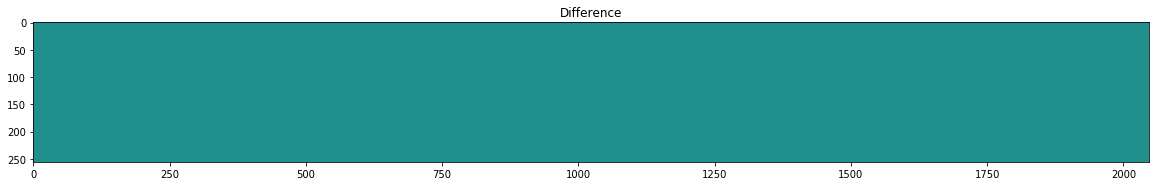

In [12]:
flatfield = fits.open('data/jwst_niriss_flat_0181.fits')
fdata = flatfield['SCI'].data[-256:,:]
corrected = hdul_wcs['SCI'].data[0,:,:]/fdata

plt.figure(figsize=(20,10))
plt.title('WCS products divided by flat field')
im = plt.imshow(hdul_wcs['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Flat Fielded pipeline products')
im = plt.imshow(hdul_flat['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Difference')
im = plt.imshow(corrected - hdul_flat['SCI'].data[0,:,:])
im.set_clim(-100,100)

All right! It seems flat fielding was indeed applied. Let's inspect one column to see how big the difference is. Let's say, column 1500 in the first integration:

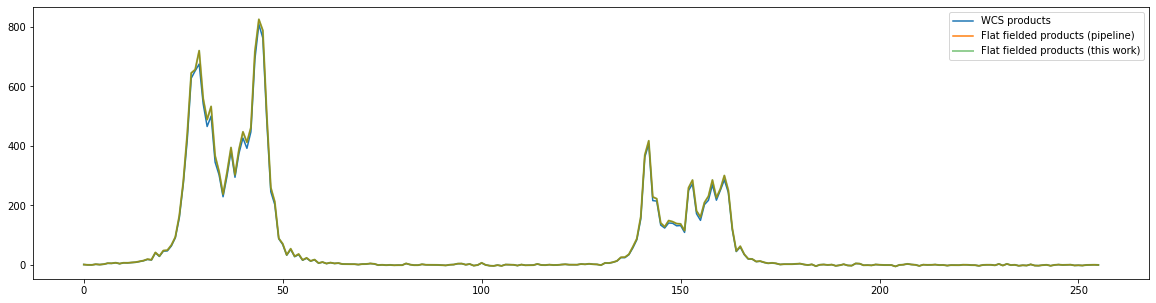

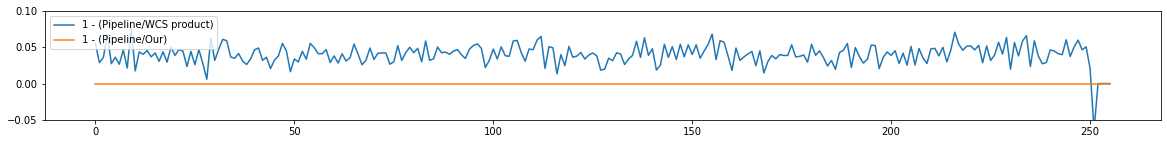

In [13]:
plt.figure(figsize=(20,5))
plt.plot(hdul_wcs['SCI'].data[0,:,1500],label='WCS products')
plt.plot(hdul_flat['SCI'].data[0,:,1500],label='Flat fielded products (pipeline)')
plt.plot(corrected[:,1500],lw=2,alpha=0.5,label='Flat fielded products (this work)')
plt.legend()

plt.figure(figsize=(20,2))
plt.plot(1.-(hdul_wcs['SCI'].data[0,:,1500]/hdul_flat['SCI'].data[0,:,1500]),label='1 - (Pipeline/WCS product)')
plt.plot(1.-(corrected[:,1500]/hdul_flat['SCI'].data[0,:,1500]),label='1 - (Pipeline/Our)')
plt.ylim([-0.05,0.1])
plt.legend()

All right, so differences are on the order of ~5% absolute flux, but vary at around ~2%. Furthermore, our corrections are exactly the same as the ones the pipeline applies. <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='srctype'> The `srctype` step </a>

This step applies populates the “SRCTYPE” keyword --- for TSOs, this should default to “POINT”. Let's test this:

In [43]:
calwebb_spec2.srctype_step.SourceTypeStep.call('output/data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits', output_dir='output',save_results=True)

2020-07-31 00:06:46,962 - CRDS - ERROR -  Error determining best reference for 'pars-sourcetypestep'  =   Unknown reference type 'pars-sourcetypestep'
2020-07-31 00:06:46,966 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2020-07-31 00:06:47,632 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args ('output/data_k2-141_superbiasstep_corrected_1_flatfieldstep.fits',).
2020-07-31 00:06:47,634 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-31 00:06:50,059 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NIS_SOSS
2020-07-31 00:06:50,060 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = None
2020-07-31 00:06:50,061 - stpipe.SourceTypeStep - WARNING - SRCTYAPT keyword not fo

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits>

Indeed, the pipeline states that because this is a TSO exposure, `SRCTYPE` is set to `POINT`. Let's check this indeed is the case:

In [45]:
hdul_srctype = fits.open('output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits')
print('SRCTYPE was:', hdul_flat['SCI'].header['SRCTYPE'])
print('SRCTYPE is:', hdul_srctype['SCI'].header['SRCTYPE'])

SRCTYPE was: POINT
SRCTYPE is: POINT


Perfect! <font color='green'>**We consider the step validated from the NIRISS/SOSS point of view.**</font>

## <a id='photom'> The `photom` step </a>

This step performs flux calibrations to our data, converting units from countrates to flux densities and/or surface brightness. Let's apply that to our `sourcetype` outputs:

In [47]:
calwebb_spec2.photom_step.PhotomStep.call('output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits', output_dir='output',save_results=True)

2020-07-31 00:15:42,809 - CRDS - ERROR -  Error determining best reference for 'pars-photomstep'  =   Unknown reference type 'pars-photomstep'
2020-07-31 00:15:42,812 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2020-07-31 00:15:43,157 - stpipe.PhotomStep - INFO - Step PhotomStep running with args ('output/data_k2-141_superbiasstep_corrected_1_sourcetypestep.fits',).
2020-07-31 00:15:43,161 - stpipe.PhotomStep - INFO - Step PhotomStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2020-07-31 00:15:47,181 - stpipe.PhotomStep - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_niriss_photom_0037.fits
2020-07-31 00:15:47,183 - stpipe.PhotomStep - INFO - Using area reference file: N/A
2020-07-31 00:15:50,565 - stpipe.PhotomStep - INFO

<CubeModel(308, 256, 2048) from data_k2-141_superbiasstep_corrected_1_photomstep.fits>

All right! It seems it worked. Let's compare the values:

In [34]:
hdul_photom = fits.open('output/data_k2-141_superbiasstep_corrected_1_photomstep.fits')
hdul_photom.info()

Filename: output/data_k2-141_superbiasstep_corrected_1_photomstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     188   ()      
  1  SCI           1 ImageHDU        24   (2048, 256, 308)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 308)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 308)   int32 (rescales to uint32)   
  4  WAVELENGTH    1 ImageHDU         9   (2048, 256)   float32   
  5  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  6  VAR_POISSON    1 ImageHDU        10   (2048, 256, 308)   float32   
  7  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 308)   float32   
  8  VAR_FLAT      1 ImageHDU        10   (2048, 256, 308)   float32   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [50440762B]   


2020-08-03 23:35:39,997 - stpipe - WARNING - /Users/nespinoza/anaconda3/envs/exoctk-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]



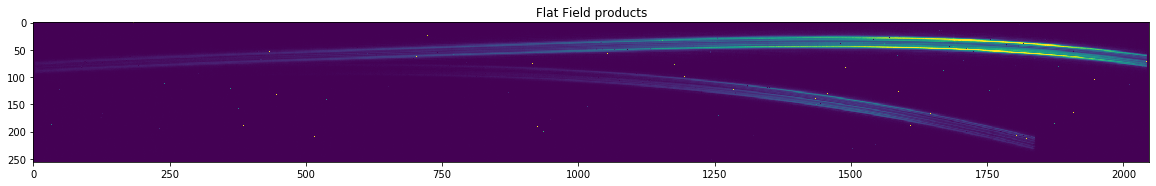

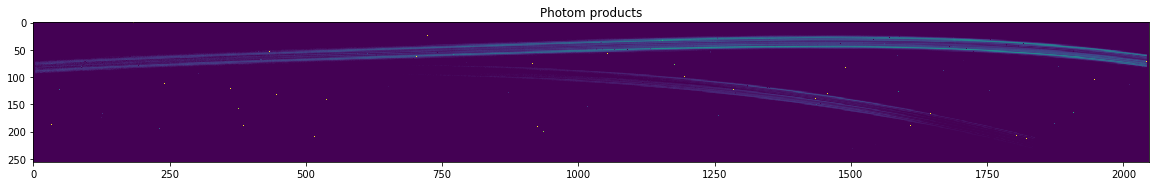

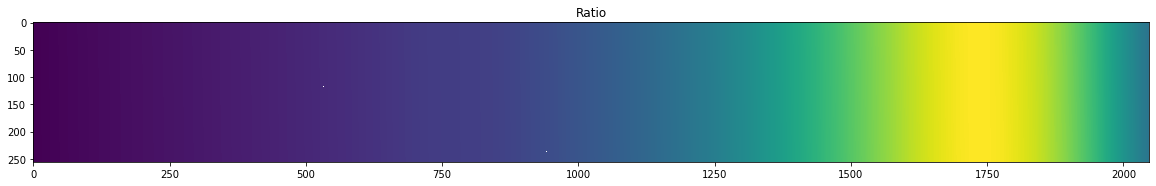

In [35]:
plt.figure(figsize=(20,10))
plt.title('Flat Field products')
im = plt.imshow(hdul_flat['SCI'].data[0,:,:])
im.set_clim(0,1000)

plt.figure(figsize=(20,10))
plt.title('Photom products')
im = plt.imshow(hdul_photom['SCI'].data[0,:,:])
im.set_clim(1e-8,3e-7)

plt.figure(figsize=(20,10))
plt.title('Ratio')
im = plt.imshow(hdul_flat['SCI'].data[0,:,:]/hdul_photom['SCI'].data[0,:,:])
#im.set_clim(-100,100)

What if we do the correction on our own? Let's explore the reference file shape:

In [37]:
photom = fits.open('data/jwst_niriss_photom_0037.fits')
photom.info()
print(photom['PRIMARY'].data)
#print(photom['PHOTOM'].data[0]['CLEAR']['GR700XD'])
print(photom['PHOTOM'].data[0])
print(photom['PHOTOM'].data[1])
print(photom['PHOTOM'].data[2])

Filename: data/jwst_niriss_photom_0037.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1  PHOTOM        1 BinTableHDU     34   4R x 9C   [12A, 15A, I, E, E, I, 5000E, 5000E, 5000E]   
None
('CLEAR', 'GR700XD', 1, 1.396029e-10, 0.0, 1793, array([0.80057, 0.80171, 0.80286, ..., 0.     , 0.     , 0.     ],
      dtype=float32), array([3.112794, 2.364255, 2.342621, ..., 0.      , 0.      , 0.      ],
      dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))
('CLEAR', 'GR700XD', 2, 1.396029e-10, 0.0, 1796, array([0.63523, 0.63568, 0.63613, ..., 0.     , 0.     , 0.     ],
      dtype=float32), array([4.180278, 3.665225, 3.635282, ..., 0.      , 0.      , 0.      ],
      dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))
('CLEAR', 'GR700XD', 3, 1.396029e-10, 0.0, 214, array([0.63515, 0.63545, 0.63576, ..., 0.     , 0.     , 0.     ],
      dtype=float32), array([243.6196, 186.6723, 187

It seems there is a different correction depending on the SOSS order. Interestingly, it seems only one correction is applied? Would be good to check. Also, it is not straightforward to understand how to do the correction with these reference files. We'll leave this in **TODO**.

Let's do a close-up to one column to see how the photom-corrected flux looks like:

Text(0.5, 0, 'Row number')

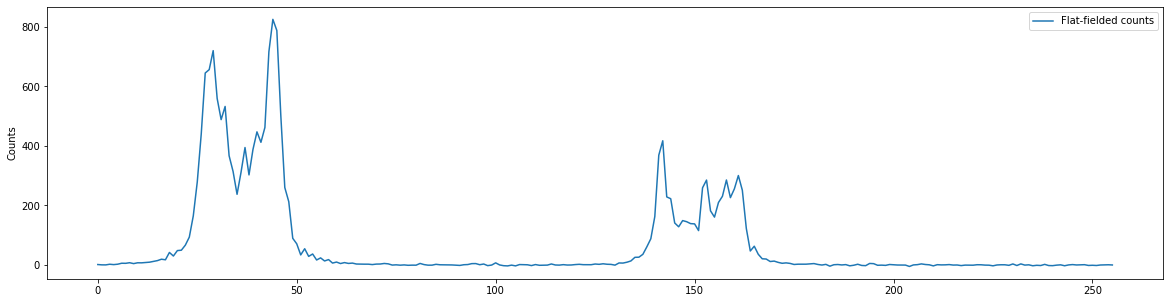

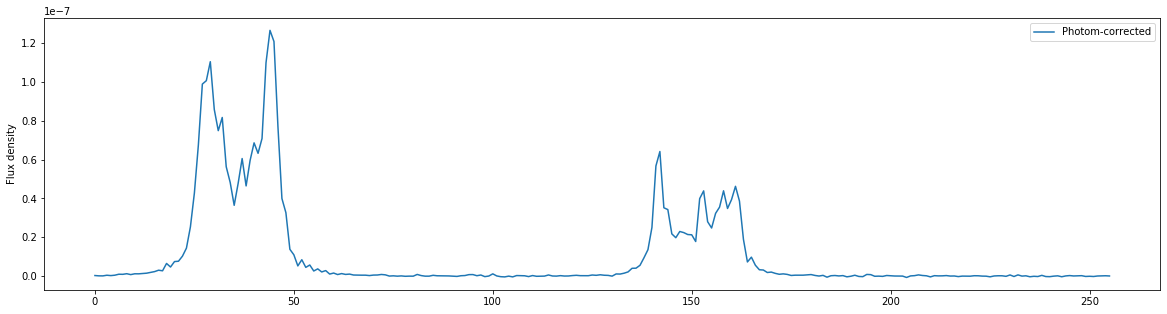

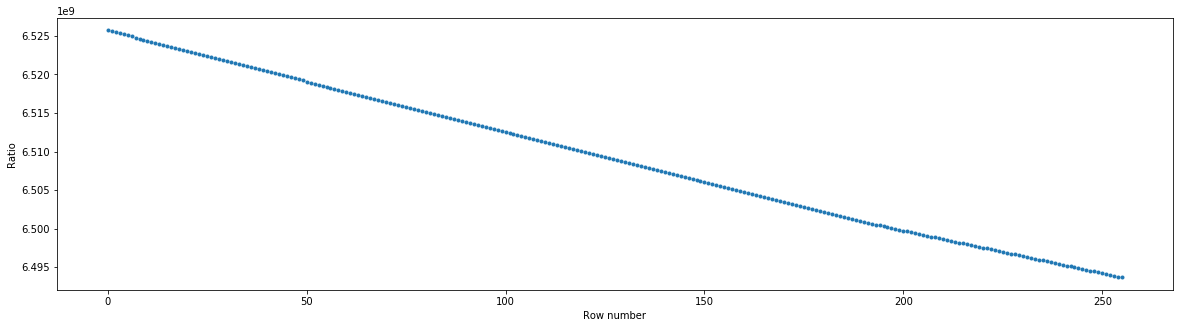

In [73]:
plt.figure(figsize=(20,5))
plt.plot(hdul_flat['SCI'].data[0,:,1500],label='Flat-fielded counts')
plt.legend()
plt.ylabel('Counts')

plt.figure(figsize=(20,5))
plt.plot(hdul_photom['SCI'].data[0,:,1500],label='Photom-corrected')
plt.legend()
plt.ylabel('Flux density')

plt.figure(figsize=(20,5))
plt.ylabel('Ratio')
plt.plot(hdul_flat['SCI'].data[0,:,1500]/hdul_photom['SCI'].data[0,:,1500],'.')
plt.xlabel('Row number')

Still not sure what this is doing. Need to check the reference file.

## <a id='extract1d'> The `extract1d` step </a>

This step performs 1D spectral extraction. Let's see what it does first on the `photom` products:

In [91]:
calwebb_spec2.extract_1d_step.Extract1dStep.call('output/data_k2-141_superbiasstep_corrected_1_photomstep.fits', output_dir='output',save_results=True)

2020-07-31 12:57:17,722 - CRDS - ERROR -  Error determining best reference for 'pars-extract1dstep'  =   Unknown reference type 'pars-extract1dstep'
2020-07-31 12:57:17,728 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2020-07-31 12:57:18,159 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('output/data_k2-141_superbiasstep_corrected_1_photomstep.fits',).
2020-07-31 12:57:18,161 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'output', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'apply_nod_offset': None}
2020-07-31 12:57:21,719 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_niriss_extra

<MultiSpecModel from data_k2-141_superbiasstep_corrected_1_extract1dstep.fits>

Let's check out (a) the reference file used to perform the extraction and (b) the extracted products. First, the reference file:

In [92]:
cat data/jwst_niriss_extract1d_0003.json

{
    "REFTYPE": "EXTRACT1D",
    "INSTRUME": "NIRISS",
    "TELESCOP": "JWST",
    "DETECTOR": "NIS",
    "EXP_TYPE": "NIS_SOSS",
    "PEDIGREE": "GROUND",
    "DESCRIP": "NIRISS SOSS extraction params for ground testing",
    "AUTHOR": "M.Wolfe, H.Bushouse",
    "HISTORY": "This reference file is for used in Build 7.1 of the JWST Calibraton pipeline. The regions are rectagular and do not follow the trace.",
    "USEAFTER": "2015-11-01T00:00:00",
    "apertures": [

        {
        "id": "FULL",
        "region_type": "target",
        "bkg_coeff": [[2014.5],[2043.5]],
        "xstart":    4,
        "xstop":  2044,
        "ystart": 1792,
        "ystop":  1972,
        "dispaxis": 1,
        "extract_width": 201
        },

        {
        "id": "SUBSTRIP256",
        "region_type": "target",
        "bkg_coeff": [[221.5],[251.5]],
        "xstart":   4,
        "xstop": 2044,
        "ystart": 20,
        "ystop":  220,
        "dispaxis": 1,
        "extract_width": 201
      

From the comments above, we can see that the `extract1d` extraction currently implemented for SOSS do not follow the trace but, rather, define a rectangular region from pixel 4 to 2044 in the columns, and pixel 20 to 220 in the rows. So, something like:

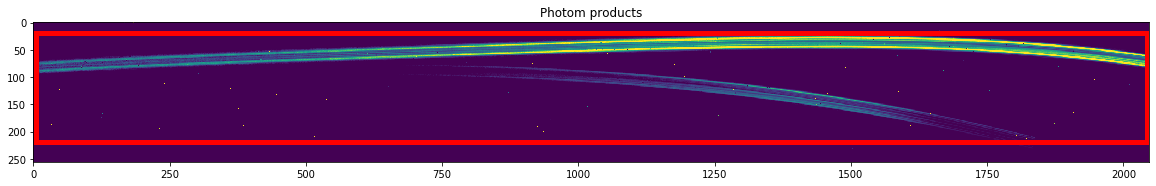

In [38]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Photom products')
im = plt.imshow(hdul_photom['SCI'].data[0,:,:])
im.set_clim(1e-8,1e-7)
rect = Rectangle((4,20),2040,200,linewidth=5,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

This is evidently non-optimal right now, as this encompassess all the orders, and extracts a diluted spectrum in most of the wavelength range. Let's look at the products nonetheless:

In [71]:
hdul_photom_e1d = fits.open('output/data_k2-141_superbiasstep_corrected_1_extract1dstep.fits')
print(hdul_photom_e1d.info())

Filename: output/data_k2-141_superbiasstep_corrected_1_extract1dstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     193   ()      
  1  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  2  EXTRACT1D     1 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  3  EXTRACT1D     2 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  4  EXTRACT1D     3 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  5  EXTRACT1D     4 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  6  EXTRACT1D     5 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  7  EXTRACT1D     6 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  8  EXTRACT1D     7 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
  9  EXTRACT1D     8 BinTableHDU     41   2041R x 9C   [D, D, D, D, D, J, D, D, D]   
 10  EXTRACT1D     9 BinTableHDU     41   2041R 

926  ASDF          1 BinTableHDU     11   1R x 1C   [30215658B]   
None


Evidently the output seems complicated to read on first sight. However, as it is explained in the documentation, this is a `MultiSpecModel` data-type, so let's open the output using that format:

In [72]:
spec = datamodels.MultiSpecModel(hdul_photom_e1d)

The `MultiSpecModel` might seem like an extra complication, but it is really helpful and simplifies our life. To access the spectra of each integration, we just do `spec.spec[i]`, where `i` is an integer. For NIRISS/SOSS, however, right now the pipeline dumps the spectra/wavelenght range corresponding to order 1 in the first $N_{integration}$ elements of `spec.spec`, the spectra of order 2 in the next $N_{integration}$ elements and the spectra for order 3 in the last $N_{integration}$ elements. In our case, $N_{integration}=308$ so `spec.spec` should have length 924. Indeed:

In [73]:
print(len(spec.spec))

924


Let's explore the first 308 elements, so we can see the spectra of order 1:

(-1, 10)

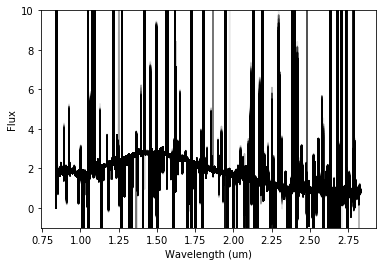

In [74]:
for i in range(308):
    plt.errorbar(spec.spec[i].spec_table['WAVELENGTH'],spec.spec[i].spec_table['FLUX'],\
                 yerr=spec.spec[i].spec_table['ERROR'],alpha=0.1,color='black')
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux')
plt.ylim([-1,10])

Well, that seems pretty bad. Again, the extraction is done in a huge rectangle, so lots of noise, lots of outliers. Let's try smoothing each spectra a little bit: 

Text(0, 0.5, 'Flux')

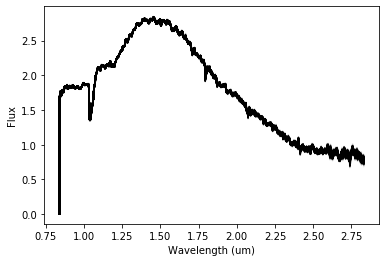

In [191]:
for i in range(308):
    plt.plot(spec.spec[i].spec_table['WAVELENGTH'],medfilt(spec.spec[i].spec_table['FLUX'],11),\
                 alpha=0.1,color='black')
plt.xlabel('Wavelength (um)')
plt.ylabel('Flux')

What if we extract the spectra? Let's do a simple sum (i.e., not worrying about edge pixelization --- simplest possible extraction), substracting in each column the background using the same region specified in the above reference file:

In [83]:
output_spectra = np.zeros([hdul_photom['SCI'].data.shape[0],2041])
for i in range(hdul_photom['SCI'].data.shape[0]):
    # Extract converting to MJy as per extract1d docs:
    output_spectra[i,:] = (np.sum(hdul_photom['SCI'].data[i,20:221,4:2045],axis=0) - \
                           np.sum(hdul_photom['SCI'].data[i,221:251,4:2045],axis=0)/30.)*1e6

Let's plot the spectra:

(-1, 10)

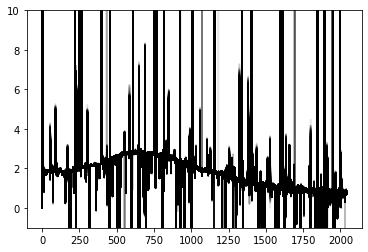

In [84]:
for i in range(hdul_photom['SCI'].data.shape[0]):
    plt.plot(output_spectra[i,::-1],alpha=0.1,color='black')
plt.ylim([-1,10])

They look pretty consistent with the one obtained by the pipeline! Let's substract them:

(-1, 1)

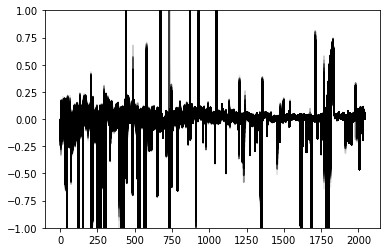

In [85]:
for i in range(hdul_photom['SCI'].data.shape[0]):
    plt.plot(output_spectra[i,:]-spec.spec[i].spec_table['FLUX'],alpha=0.1,color='black')
plt.ylim([-1,1])

Spectra are consistent, but not _exactly_ the same.